# Simple AutoEncoder

This notebook is adapted from: https://github.com/L1aoXingyu/pytorch-beginner/tree/master/08-AutoEncoder

In [1]:
import os

import torch
import torchvision
from tqdm import tqdm

from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image

In [2]:
if not os.path.exists('./mlp_img'):
    os.mkdir('./mlp_img')


def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

batch_size = 128
dataset = MNIST('./data', transform=img_transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

In [3]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3)
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128), 
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Tanh() # -1 ~ 1
        )

    def forward(self, x):
        x_ = self.encoder(x)
        out = self.decoder(x_)
        return out, x_

In [ ]:
class LossRecoder:
    def __init__(self):
        self.fig = plt.figure()
        self.ax = self.fig.add_subplot(111)
        plt.ion()
        
    def update(self, X, Y):
        self.fig.show()
        self.ax.clear()
        self.ax.set_xlabel('epoch')
        self.ax.set_ylabel('loss')
        self.ax.plot(X, Y)
        self.fig.canvas.draw()

In [114]:
import ipdb
from matplotlib.animation import FuncAnimation
from IPython.display import HTML


def train(model, criterion, optimizer, train_dataloader,
          loss_recorder=None,
          avg_loss_list=None,
          epochs=10):
    
    if avg_loss_list is None:
        avg_loss_list = []
        
    for epoch in range(epochs):
        epoch_loss = 0
        num_batches = 0
        
        for idx, data in enumerate(dataloader, start=1):
            img, _ = data
            
            img = img.view(img.size(0), -1)
            img = img.to('cuda')
          
            output, _ = model(img)
            loss = criterion(output, img)
            epoch_loss += loss
            
            # ipdb.set_trace()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            num_batches = idx
            
        avg_epoch_loss = float((epoch_loss / num_batches).data.cpu())
        avg_loss_list.append(avg_epoch_loss)
        
        # Display Loss
        if loss_recorder is not None:
            loss_recoder.update(list(range(len(avg_loss_list))), avg_loss_list)
                   
        print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, epochs, avg_epoch_loss))
        if epoch % 10 == 0:
            pic = to_img(output.cpu().data)
            save_image(pic, './mlp_img/image_{}.png'.format(epoch))
        
    return avg_loss_list

<IPython.core.display.Javascript object>


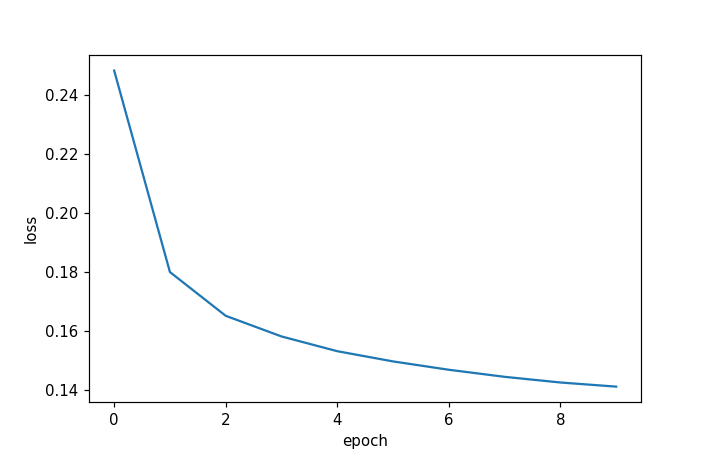

In [115]:
learning_rate = 1e-3


model = AutoEncoder().cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=learning_rate,
                             weight_decay=1e-5)
loss_recoder = LossRecoder()

In [116]:
num_epochs = 10

train(model=model,
      criterion=criterion,
      optimizer=optimizer,
      train_dataloader=dataloader,
      loss_recorder=loss_recorder,
      epochs=num)

epoch [1/10], loss:0.2481
epoch [2/10], loss:0.1800
epoch [3/10], loss:0.1652
epoch [4/10], loss:0.1582
epoch [5/10], loss:0.1532
epoch [6/10], loss:0.1497
epoch [7/10], loss:0.1469
epoch [8/10], loss:0.1445
epoch [9/10], loss:0.1426
epoch [10/10], loss:0.1412


[0.24810078740119934,
 0.17995521426200867,
 0.16516660153865814,
 0.15818500518798828,
 0.15319649875164032,
 0.14973850548267365,
 0.14691750705242157,
 0.14452742040157318,
 0.14261123538017273,
 0.1412116438150406]

## Analysis

In [64]:
torch.save(model.state_dict(), './sim_autoencoder.pth')

In [ ]:
!pip install tqdm
!pip install ipdb
!pip install torch-lr-finder